# Initialize

## Import functionality

In [6]:
from os.path import join

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

## Load and merge sentiment data

* https://www.kaggle.com/datasets/ankurzing/aspect-based-sentiment-analysis-for-financial-news
* https://www.kaggle.com/datasets/ankurzing/sentiment-analysis-for-financial-news
* https://www.kaggle.com/datasets/sbhatti/financial-sentiment-analysis

In [2]:
# Source folder
SOURCE_DATA_FOLDER = ['..','datasets']
# Data sets
SOURCE_DATA = {
    'AA':[['kaggle','ankurzing','SEntFiN-v1.1.csv'],'utf-8', False],
    'AS':[['kaggle','ankurzing','all-data.csv'],'ansi', False],
    'SB':[['kaggle','sbhatti','data.csv'],'utf-8', False]
}
# SOURCE_DATA processing functions
PROCESSORS = {}
# Dictionary of word to WStat instance
WORDS:dict = {}
# List of samples where each sample is a tuple[SAMPLE_SCORE,list[tuple[WORD,WORD_COUNT]]]
TEXTS:list = []

In [3]:
# Word statistics containing count and score where score is the sum of
# points. A point is -1, 0 or 1 (sentiment class).
class WStat:
    def __init__(self, score, count) -> None:
        self.score = score
        self.count = count
    def add(self, point, count):
        self.score += point
        self.count += count
    def get_score(self): return self.score
    def get_count(self): return self.count
# Add sample words to 'dst' (WORDS) and 'txt' (TEXTS)
def add_words(point, words:list[str], dst:dict[WStat], txt:list):
    wmap = {}
    # histogram
    for w in words:
        if w in wmap: wmap[w] += 1
        else: wmap[w] = 1
    # add histogram entries to corresponding WStat
    for word,count in wmap.items():
        if word in dst:
            dst[word].add(point,count) # add to existing
        else:
            dst[word] = WStat(point,count) # new
    # append sample
    txt.append((point, wmap.items()))
# Process set ankurzing aspect-based.
def prep_ankurzing_asp(df_src:pd.DataFrame, dst:dict, txt:dict):
    for _,row in df_src.iterrows():
        # get sentiment classification
        sentiment = row['Decisions']
        sentiment = sentiment[sentiment.find(':')+3]
        # score
        if sentiment=='p': point = 1
        elif sentiment=='n': point = -1
        else: point = 0
        # get text words
        add_words(point, row['Title'].lower().split(), dst, txt)
PROCESSORS['AA'] = prep_ankurzing_asp
# Process set ankurzing sentiment.
def prep_ankurzing_sent(df_src:pd.DataFrame, dst:dict, txt:dict):
    for _,row in df_src.iterrows():
        # get sentiment classification
        sentiment = row[0]
        # score
        if sentiment=='positive': point = 1
        elif sentiment=='negative': point = -1
        else: point = 0
        # get text words
        add_words(point, row[1].lower().split(), dst, txt)
PROCESSORS['AS'] = prep_ankurzing_sent
# Process set sbhatti financial.
def prep_sbhatti(df_src:pd.DataFrame, dst:dict, txt:dict):
    for _,row in df_src.iterrows():
        # get sentiment classification
        sentiment = row['Sentiment']
        # score
        if sentiment=='positive': point = 1
        elif sentiment=='negative': point = -1
        else: point = 0
        # get text words
        add_words(point, row['Sentence'].lower().split(), dst, txt)
PROCESSORS['SB'] = prep_sbhatti

In [4]:
# Load and process data sets
for k in SOURCE_DATA:
    item = SOURCE_DATA[k]
    if not item[2]:
        # Read in as dataframe
        df = pd.read_csv(join(*SOURCE_DATA_FOLDER, *item[0]), encoding=item[1])
        # Process
        PROCESSORS[k](df, WORDS, TEXTS)

## Pre-process data

In [5]:
# Create word table for analysis. 
_words = []
_counts = []
_scores = []
for k in WORDS:
    _words.append(k)
    _scores.append(WORDS[k].get_score())
    _counts.append(WORDS[k].get_count())
df_words = pd.DataFrame({
    'Word':pd.Series(_words, dtype='str'),
    'Count':pd.Series(_counts, dtype='int16'),
    'Score':pd.Series(_scores, dtype='float32')
})

print(df_words.head())
print(df_words.shape)
print(df_words.dtypes)

       Word  Count  Score
0  spicejet     23    1.0
1        to   8192  247.0
2     issue    168  -48.0
3       6.4     11    0.0
4     crore    911  -28.0
(25780, 3)
Word      object
Count      int16
Score    float32
dtype: object


<AxesSubplot: title={'center': 'Word scores and occurences.'}, xlabel='Word Score', ylabel='Word Occurence'>

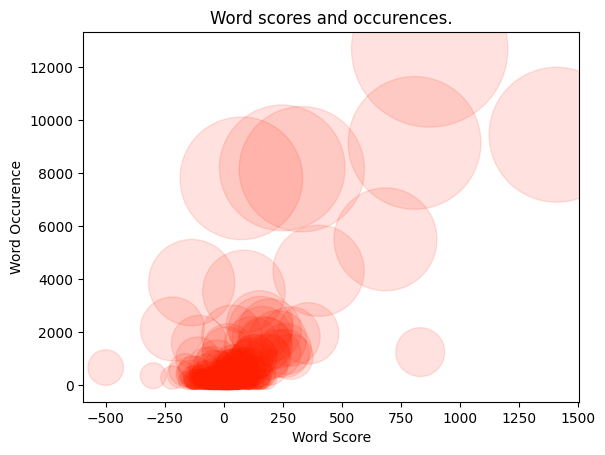

In [17]:
# Plot 
df_words.plot(y='Count',x='Score', s='Count', c='#FF1F0020', kind='scatter', xlabel='Word Score', ylabel='Word Occurence', title='Word scores and occurences.')

### Analysis

From the plot we can determine that:

1. our trainint data is unbalanced towards positive store.
2. We have many words centered acound zero score.

What we can do:

1. We SHOULD get a more varied data set that will give us a balanced distribution.
2. Filter out words around zero to optimize feature count.

Text(0.5, 1.0, 'Feature amount vs cut amount around origin')

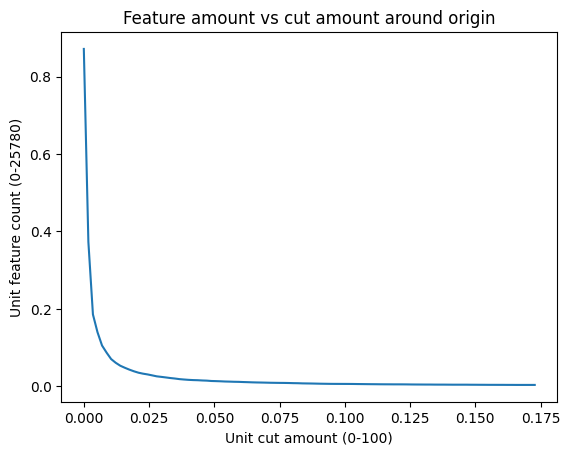

In [38]:
# Lets filter around zero
df_scores = df_words['Score']
cut_scores = []
feat_counts = []
for x_score in range(100):
    cut_scores.append(x_score)
    feat_cnt = df_scores[(df_scores < -x_score) ^ (df_scores > x_score)].shape[0]
    feat_counts.append(feat_cnt)
    
cut_scores_n = cut_scores/np.linalg.norm(cut_scores)
feat_counts_n = feat_counts/np.linalg.norm(feat_counts)

plt.plot(cut_scores_n, feat_counts_n)
plt.xlabel(f'Unit cut amount (0-100)')
plt.ylabel(f'Unit feature count (0-{df_scores.shape[0]})')
plt.title('Feature amount vs cut amount around origin')


In [33]:
#TODO cut at about 45 deg..

'''
# Cut away 
words = list(df_words.query('Score < -15 or Score > 15')['Word'])
rows = []
count = len(TEXTS)
current = 0
print('Processing')
for sentiment,word_tuples in TEXTS:
    row = np.zeros(len(words)+1,dtype=np.float32)
    row[0] = sentiment
    for w,c in word_tuples:
        try:
            idx = words.index(w)+1
            row[idx] = c
        except: pass
    rows.append(row)
    current += 1
    if current % 2100 == 0:
        print(f'Row {current} of {count}.')

# Create feature dataframe
print('Creating DataFrame.')
df_features = pd.DataFrame(rows, columns=['SCORE']+words)
print('Writing DataFrame to file.')
df_features.to_csv(join(*SOURCE_DATA_FOLDER,'sentiment.csv'))
print('Bye.')
'''

0          NaN
1        246.0
2       -295.0
3         48.0
4        -28.0
         ...  
25775      0.0
25776      0.0
25777      2.0
25778      0.0
25779      0.0
Name: Score, Length: 25780, dtype: float32


"\n# Cut away \nwords = list(df_words.query('Score < -15 or Score > 15')['Word'])\nrows = []\ncount = len(TEXTS)\ncurrent = 0\nprint('Processing')\nfor sentiment,word_tuples in TEXTS:\n    row = np.zeros(len(words)+1,dtype=np.float32)\n    row[0] = sentiment\n    for w,c in word_tuples:\n        try:\n            idx = words.index(w)+1\n            row[idx] = c\n        except: pass\n    rows.append(row)\n    current += 1\n    if current % 2100 == 0:\n        print(f'Row {current} of {count}.')\n\n# Create feature dataframe\nprint('Creating DataFrame.')\ndf_features = pd.DataFrame(rows, columns=['SCORE']+words)\nprint('Writing DataFrame to file.')\ndf_features.to_csv(join(*SOURCE_DATA_FOLDER,'sentiment.csv'))\nprint('Bye.')\n"